In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *
from pytorch_inferno.inferno_interp import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn.functional as F
from torch import optim, autograd, nn, Tensor
import torch
from torch.distributions import Normal

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [9]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(alpha_aux=[Normal(0,2), Normal(0,2)], float_b=True, b_aux=Normal(1000,100), aug_alpha=True, n_steps=10),
               LossTracker(),SaveBest('weights/best_ii4a.h5'),EarlyStopping(10)])

1: Train=1184.786340637207 Valid=666.3264880371094
2: Train=568.9427719116211 Valid=542.8177575683594
3: Train=509.7556851196289 Valid=506.26944946289063
4: Train=481.72684814453123 Valid=486.54740051269533
5: Train=466.128366394043 Valid=472.35809814453125
6: Train=456.9115185546875 Valid=466.50775756835935
7: Train=449.491650390625 Valid=456.6458966064453
8: Train=442.6973687744141 Valid=450.4904486083984
9: Train=435.4138150024414 Valid=445.0492169189453
10: Train=432.322666015625 Valid=440.4891387939453
11: Train=429.85400451660155 Valid=437.06866638183595
12: Train=426.789892578125 Valid=431.27662841796877
13: Train=422.3719223022461 Valid=430.81610778808596
14: Train=419.3687469482422 Valid=427.13031311035155
15: Train=418.35854064941407 Valid=428.2555181884766
16: Train=415.35207305908204 Valid=423.85337890625
17: Train=413.94309204101563 Valid=420.5671057128906
18: Train=413.0072131347656 Valid=421.5962811279297
19: Train=412.09086334228516 Valid=419.45018615722654
20: Train=40

156: Train=337.6607354736328 Valid=348.05255798339846
157: Train=337.18481018066404 Valid=349.31084899902345
158: Train=337.53812850952147 Valid=347.0970068359375
159: Train=338.03192153930667 Valid=348.14772705078127
160: Train=336.6875915527344 Valid=349.51820373535156
161: Train=338.48641998291015 Valid=347.4960760498047
162: Train=338.1659817504883 Valid=348.8708685302734
163: Train=337.046918182373 Valid=348.3848864746094
164: Train=336.3491607666016 Valid=348.1805615234375
165: Train=337.47059799194335 Valid=348.84959228515623
166: Train=337.5810754394531 Valid=348.3734307861328
167: Train=336.8632125854492 Valid=348.78681701660156
168: Train=338.16922897338867 Valid=348.19946533203125
Early stopping
Loading best model with loss 347.0970068359375
CPU times: user 55min 51s, sys: 5min 44s, total: 1h 1min 36s
Wall time: 58min 4s


In [10]:
model.save('weights/Inferno_Test_interp_bm4a.h5')

In [11]:
model.load('weights/Inferno_Test_interp_bm4a.h5')

# Results

## BM 0

In [12]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [13]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,0,1.0
1,8,1.0
2,0,1.0
3,8,1.0
4,0,1.0


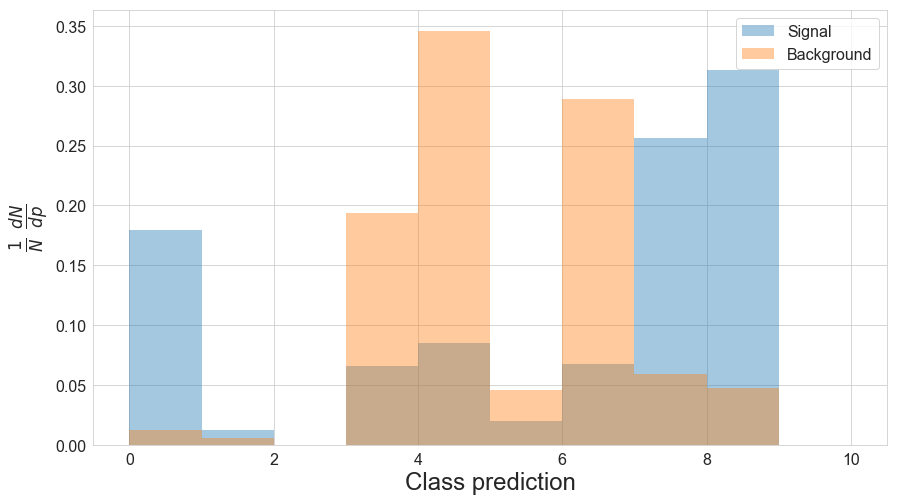

In [14]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [15]:
bin_preds(df)

In [16]:
df.head()

,pred,gen_target,pred_bin
0,0,1.0,0
1,8,1.0,8
2,0,1.0,0
3,8,1.0,8
4,0,1.0,0


In [17]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [18]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [19]:
f_s, f_b

(tensor([1.7912e-01, 1.2548e-02, 2.0000e-13, 6.5500e-02, 8.5432e-02, 1.9902e-02,
         6.7462e-02, 2.5661e-01, 3.1342e-01, 2.0000e-13]),
 tensor([1.2412e-02, 5.7700e-03, 2.0000e-13, 1.9395e-01, 3.4610e-01, 4.5910e-02,
         2.8910e-01, 5.9180e-02, 4.7586e-02, 2.0000e-13]))

In [20]:
asimov = (50*f_s)+(1000*f_b)

In [21]:
asimov, asimov.sum()

(tensor([2.1368e+01, 6.3974e+00, 2.1000e-10, 1.9722e+02, 3.5037e+02, 4.6905e+01,
         2.9247e+02, 7.2011e+01, 6.3257e+01, 2.1000e-10]), tensor(1050.))

In [22]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([26.45695877, 26.31158829, 26.17235756, 26.0388298 , 25.91113472,
       25.78891563, 25.67248154, 25.56172752, 25.45627022, 25.35608101,
       25.2612915 , 25.17206192, 25.08747101, 25.00811768, 24.93384552,
       24.86487198, 24.80053711, 24.74102211, 24.68627548, 24.63622475,
       24.59083748, 24.55001068, 24.51359367, 24.48173523, 24.45437431,
       24.43143082, 24.41249275, 24.39806366, 24.38754463, 24.38162231,
       24.37936211, 24.38135529, 24.38747978, 24.39740944, 24.41158295,
       24.42930222, 24.45107269, 24.47632217, 24.50550079, 24.53844833,
       24.57491684, 24.61532784, 24.65895081, 24.70629692, 24.75716209,
       24.81133461, 24.86924171, 24.93038559, 24.99526978, 25.06281281,
       25.13412476, 25.20848274, 25.28631783, 25.36738396, 25.4511776 ,
       25.53857803, 25.62873459, 25.72228432, 25.81900406, 25.91830444,
       26.02091599])

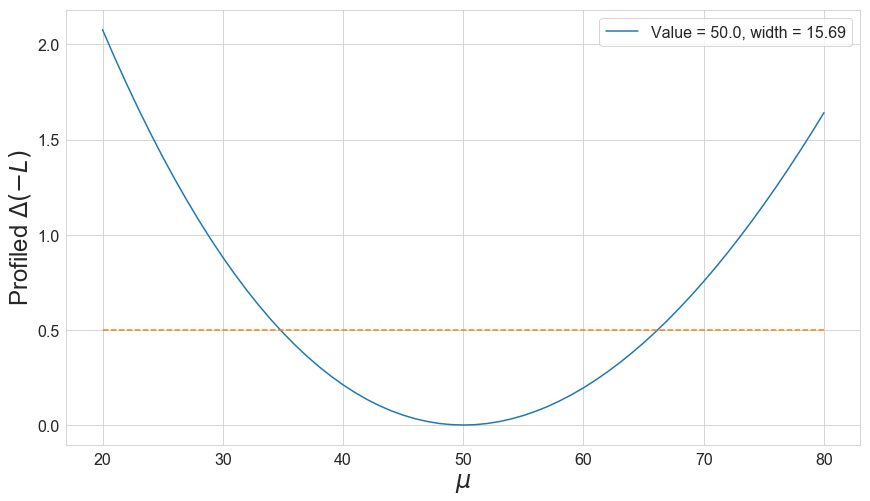

In [23]:
plot_likelihood(y-y.min())

# Nuisances - via interpolation

In [24]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [25]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [26]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,0,1.0,0,0,0,0,0,0,0,0,0,0,0
1,8,1.0,8,8,8,8,8,8,8,8,8,8,8
2,0,1.0,0,0,0,0,0,0,0,0,0,0,0
3,8,1.0,8,8,8,8,8,8,8,8,8,8,8
4,0,1.0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,6,0.0,6,6,6,6,6,6,6,6,6,6,6
999996,6,0.0,6,6,6,6,6,6,6,6,6,6,6
999997,6,0.0,6,6,6,6,6,6,6,6,6,6,6
999998,4,0.0,4,6,6,4,4,4,4,4,4,4,4


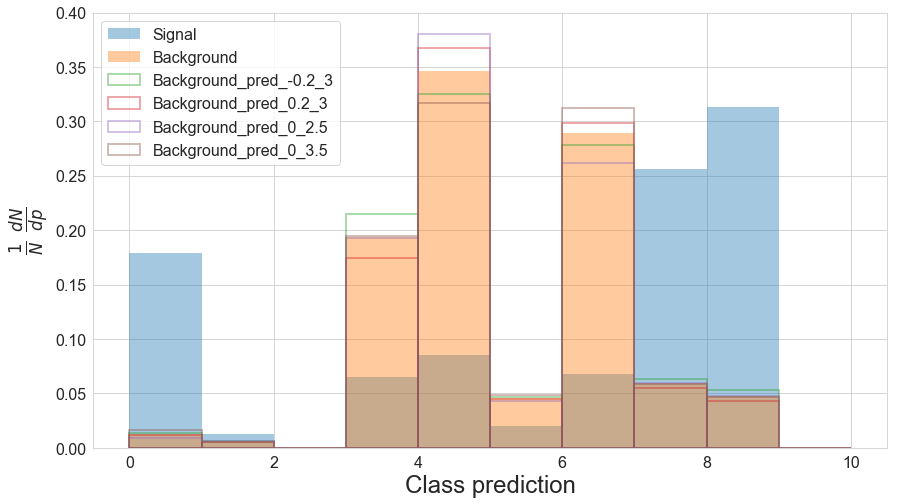

In [27]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([9.8840e-03, 6.5220e-03, 2.0000e-13, 2.1373e-01, 3.5938e-01, 4.3196e-02,
        2.5121e-01, 6.3034e-02, 5.3044e-02, 2.0000e-13])
tensor([1.3586e-02, 6.0380e-03, 2.0000e-13, 2.1472e-01, 3.2490e-01, 4.6548e-02,
        2.7864e-01, 6.2806e-02, 5.2756e-02, 2.0000e-13])
tensor([1.7894e-02, 5.7360e-03, 2.0000e-13, 2.1567e-01, 2.9536e-01, 4.9262e-02,
        3.0171e-01, 6.2150e-02, 5.2226e-02, 2.0000e-13])
tensor([8.7100e-03, 6.2540e-03, 2.0000e-13, 1.9296e-01, 3.8058e-01, 4.2558e-02,
        2.6166e-01, 5.9408e-02, 4.7874e-02, 2.0000e-13])
tensor([1.2412e-02, 5.7700e-03, 2.0000e-13, 1.9395e-01, 3.4610e-01, 4.5910e-02,
        2.8910e-01, 5.9180e-02, 4.7586e-02, 2.0000e-13])
tensor([1.6720e-02, 5.4680e-03, 2.0000e-13, 1.9489e-01, 3.1655e-01, 4.8624e-02,
        3.1217e-01, 5.8524e-02, 4.7056e-02, 2.0000e-13])
tensor([7.6080e-03, 6.0840e-03, 2.0000e-13, 1.7329e-01, 4.0143e-01, 4.1510e-02,
        2.7146e-01, 5.5550e-02, 4.3070e-02, 2.0000e-13])
tensor([1.1310e-02, 5.6000e-03, 2.0000e-1

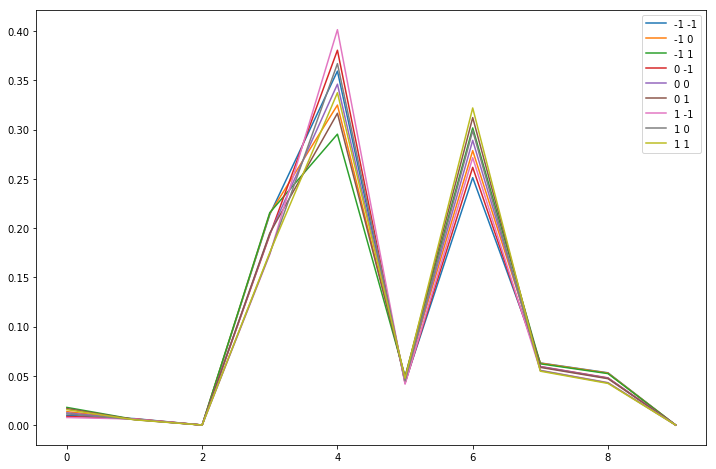

In [28]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [29]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [30]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [31]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [32]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [33]:
nll = to_np(nll)

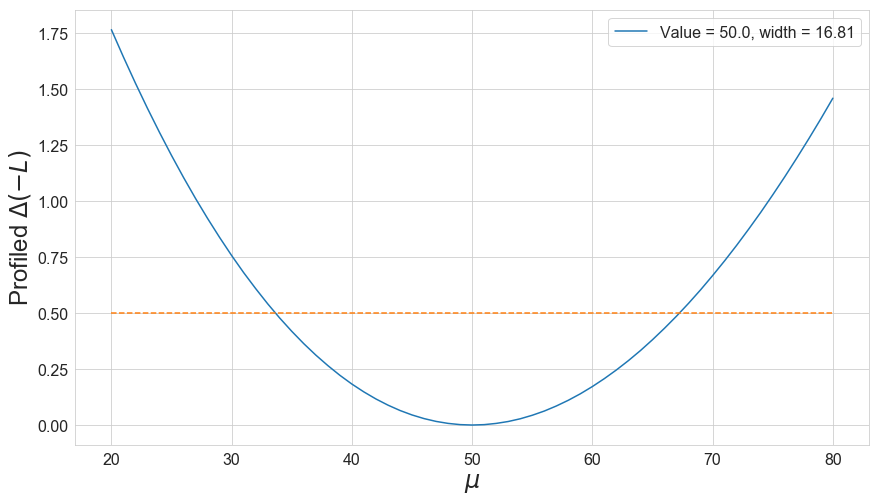

In [34]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [35]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [36]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [37]:
nll = to_np(nll)

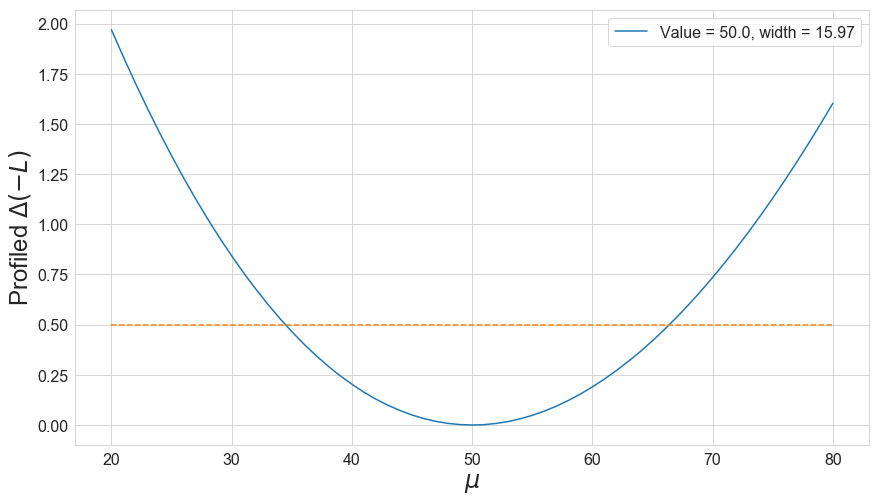

In [38]:
plot_likelihood(nll-nll.min())

## BM 2

In [39]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [40]:
nll = to_np(nll)

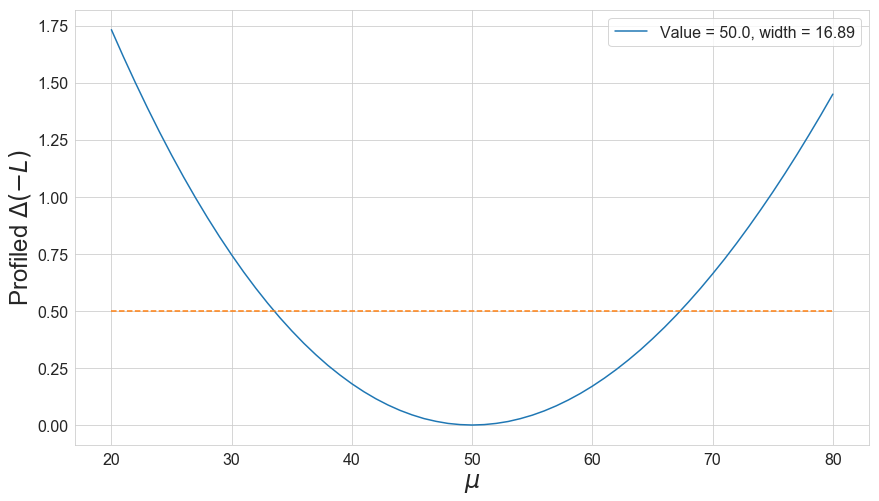

In [41]:
plot_likelihood(nll-nll.min())

## BM 3

In [42]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [43]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, **b_shapes)

In [44]:
nll = to_np(nll)

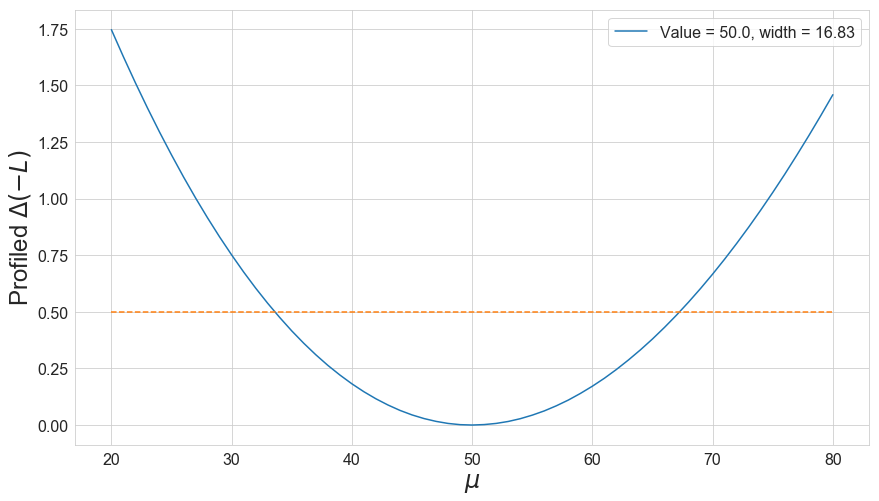

In [45]:
plot_likelihood(nll-nll.min())

## BM 4

In [46]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [47]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, float_b=True, b_aux=Normal(1000,100), **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.3220,  0.1055, 25.4552])
Linear regime: Mu 21.0, alpha tensor([-0.3105,  0.1010, 24.5306])
Linear regime: Mu 22.0, alpha tensor([-0.2991,  0.0965, 23.6117])
Linear regime: Mu 23.0, alpha tensor([-0.2877,  0.0921, 22.6986])
Linear regime: Mu 24.0, alpha tensor([-0.2764,  0.0877, 21.7912])
Linear regime: Mu 25.0, alpha tensor([-0.2651,  0.0835, 20.8894])
Linear regime: Mu 26.0, alpha tensor([-0.2539,  0.0794, 19.9932])
Linear regime: Mu 27.0, alpha tensor([-0.2427,  0.0753, 19.1024])
Linear regime: Mu 28.0, alpha tensor([-0.2316,  0.0713, 18.2171])
Linear regime: Mu 29.0, alpha tensor([-0.2206,  0.0673, 17.3371])
Linear regime: Mu 30.0, alpha tensor([-0.2096,  0.0635, 16.4625])
Linear regime: Mu 31.0, alpha tensor([-0.1986,  0.0597, 15.5931])
Linear regime: Mu 32.0, alpha tensor([-0.1877,  0.0560, 14.7289])
Linear regime: Mu 33.0, alpha tensor([-0.1768,  0.0524, 13.8699])
Linear regime: Mu 34.0, alpha tensor([-0.1660,  0.0488, 13.0159])
Linear reg

In [48]:
nll = to_np(nll)

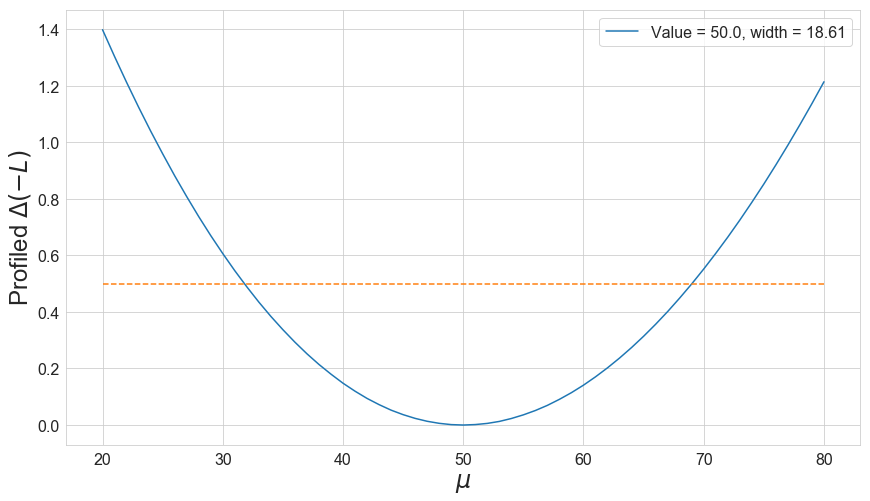

In [49]:
plot_likelihood(nll-nll.min())